##### Copyright 2019 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Valutazione modello con Scikit-learn

## Import libraries


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import itertools

from tensorflow.keras import layers

# from google.colab import drive

In [3]:
tf.__version__

'2.11.1'

## Carico il test set
Carico il test set da google drive e lo leggo come un DataFrame


In [4]:
# drive.mount('/content/drive')

# test = pd.read_csv('drive/MyDrive/test_data.csv')
test = pd.read_csv('test_data.csv')

print("first 5 row: \n", test.head(10))

first 5 row: 
    Unnamed: 0 Type  Age               Breed1  Gender  Color1    Color2   
0        7948  Dog   60               Poodle  Female   Black  No Color  \
1       10759  Dog   12          Mixed Breed    Male   Brown    Golden   
2        2206  Cat    8  Domestic Short Hair  Female   Brown      Gray   
3        4682  Cat    2  Domestic Short Hair  Female  Yellow     Cream   
4       11162  Cat    2  Domestic Short Hair  Female   White  No Color   
5        8233  Cat    6  Domestic Short Hair  Female  Yellow     White   
6        6806  Dog    4          Mixed Breed  Female   Cream     White   
7        5175  Dog    3          Mixed Breed  Female   Brown     White   
8        4767  Cat   24  Domestic Short Hair  Female    Gray  No Color   
9        9828  Dog    6   Labrador Retriever    Male   Brown  No Color   

  MaturitySize FurLength Vaccinated Sterilized   Health  Fee  PhotoAmt  target  
0        Small     Short   Not Sure         No  Healthy    1         2       1  
1       

Carico il modello tramite `tf.keras.models.load_model` e lo visualizzo attraverso `.summary()`:


In [5]:
# Use `rankdir='LR'` to make the graph horizontal.
model = tf.keras.models.load_model('mymodel/')


2023-05-26 09:42:35.250861: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Metriche e scoring: quantificare la qualità della predizioe con scikitlearn




In questa sezione discuteremo le varie metriche di valutazione de modello distribuite da scikitlearn


Scikit-learn dispone di un modulo di metriche che fornisce altre metriche che possono essere utilizzate per altri scopi, come ad esempio quando c'è uno squilibrio tra le classi, ecc. Inoltre, consente all'utente di creare metriche di valutazione personalizzate per un compito specifico.

Inizieremo importando le librerie necessarie per la nostra esercitazione e impostando alcune impostazioni predefinite.

In [6]:
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics, datasets, neighbors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, roc_auc_score
from sklearn.metrics import recall_score, f1_score, precision_recall_fscore_support, roc_curve, accuracy_score



Per prima cosa abbiamo bisogno delle previsioni del modello precedentemente addestrato da confrontare con le etichette effettive degli esempi.
In tensorflow esiste la funzione predict che restituisce la probabilità che un dato esempio appartenga a una classe; possiamo sfruttare questa informazione per ricavare le etichette degli esempi.

N.B. In questo caso abbiamo bisogno di x e y separati e non del tf.data.Dataset che abbiamo usato precedentemente

In [7]:
test_df = test.copy()
y_real = np.array(test_df.pop('target'))
x_test = {key: value for key, value in test_df.items()}
def get_prediction(model, x_test, y_test):
    predictions_prob = model.predict(x_test)
    y_pred=[]
    pred_probs=[]
    for prob in predictions_prob:
        classe = 1 if prob>0.5 else 0
        y_pred.append(classe) 
        pred_probs.append(prob)
    return y_pred, pred_probs


Ora che abbiamo le nostre etichette reali e previste, possiamo procedere al calcolo delle varie metriche sfruttando la libreria scikitlearn e mostrarle tramite matplotlib.



In [8]:
def plot_matrix(conf_mat):
    with plt.style.context(('ggplot', 'seaborn')):
        fig = plt.figure(figsize=(10,10), num=1)
        plt.imshow(conf_mat, interpolation='nearest',cmap= plt.cm.Blues )
        plt.xticks([0,1],[0,1])
        plt.yticks([0,1],[0,1])
        plt.xlabel('Predicted Label')
        plt.ylabel('Actual Label')
        labels = np.array([['TN', 'FP'],['FN', 'TP']])
        for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
            text = f"{labels[i,j] }\n{conf_mat[i, j]}\n{(conf_mat[i, j]/np.sum(conf_mat)):.0%}"
            plt.text(j, i, text, horizontalalignment="center",color="red")
        plt.grid(None)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.show()
        return conf_mat

73/73 [==============================] - 0s 867us/step


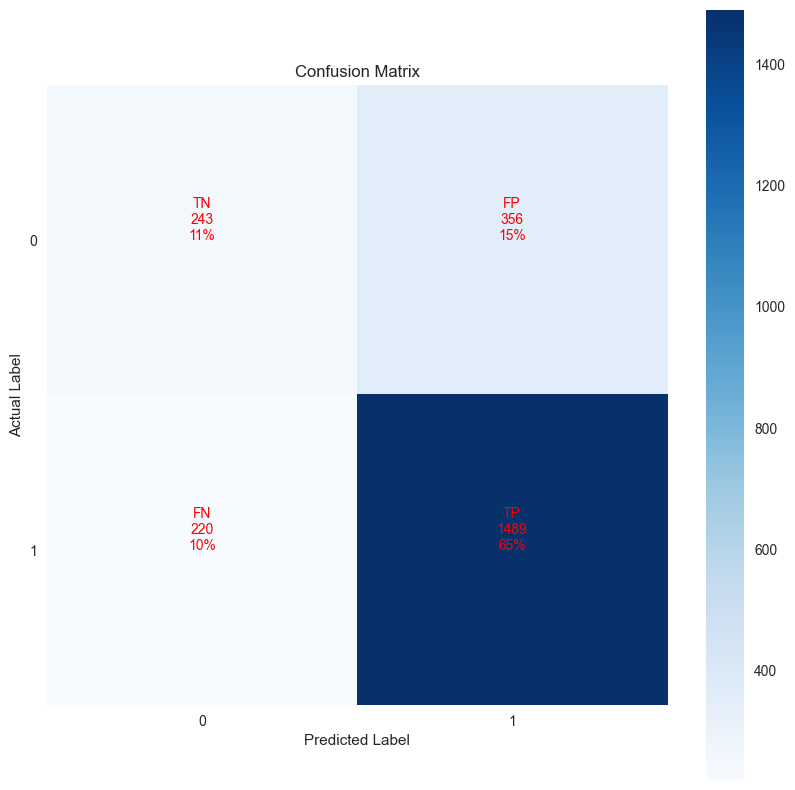

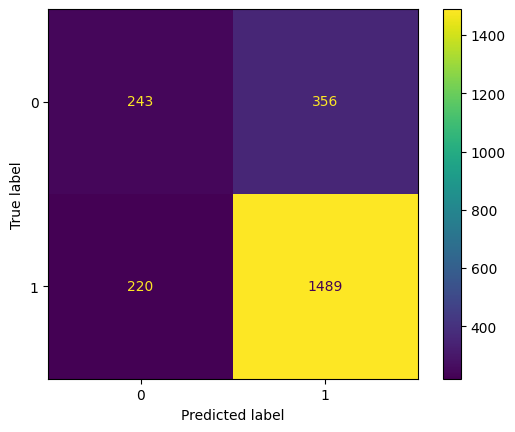

In [9]:
y_pred, prob = get_prediction(model, x_test, y_real)

conf_mat = confusion_matrix(y_real, y_pred)
plot_matrix(conf_mat)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()

In [10]:
def print_report(y_real, y_pred, conf_mat):
    [[TN, FP],[FN, TP]] = conf_mat
    print('Accuracy  : %.3f'%accuracy_score(y_real, y_pred))
    print('Precision  : %.3f'%precision_score(y_real, y_pred))
    print('Recall(TPR): %.3f'%recall_score(y_real, y_pred))
    print('F1-Score   : %.3f'%f1_score(y_real, y_pred))
    print('TNR        : %.3f'%(TN/(TN+FP)))
    print('FNR        : %.3f'%(FN/(FN+TP)))

In [11]:
print_report(y_real, y_pred, conf_mat)

Accuracy  : 0.750
Precision  : 0.807
Recall(TPR): 0.871
F1-Score   : 0.838
TNR        : 0.406
FNR        : 0.129


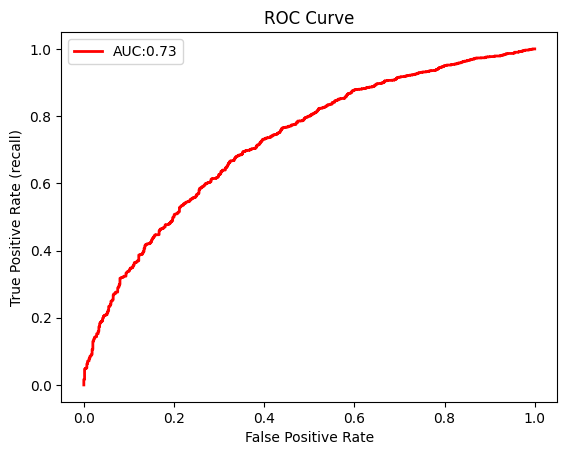

In [12]:
fpr, tpr, _ = roc_curve(y_real,  prob)
auc = roc_auc_score(y_real, prob)
 
plt.figure()
plt.plot(fpr, tpr, label="AUC:%.2f" % (auc), linewidth=2, c='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()